# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import json
import requests
import pandas as pd
import numpy as np 
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
#converted to .json
BTC_data = requests.get(btc_url).json()
# Fetch current ETH price
#converted to .json
ETH_data = requests.get(eth_url).json()

# Compute current value of my crypto
#get the current price of 1 bitcoin and 1 ethereum in USD
my_btc_price = BTC_data['data']['1']['quotes']['USD']['price']
my_eth_price = ETH_data['data']['1027']['quotes']['USD']['price']

#mutiply the coin price by the amount of coins in the portfolio
my_btc_value = my_btc_price * my_btc
my_eth_value = my_eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $54349.20
The current value of your 5.3 ETH is $17748.22


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [8]:
# Format current date as ISO format
start_date = pd.Timestamp("2022-03-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-03-31", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start= start_date,
    end= end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']== 'AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']== 'SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
investment_portfolio = pd.concat([AGG, SPY], axis=1, keys=['AGG','SPY'])

# Preview DataFrame
investment_portfolio.head()

AGG                                   \
                             open    high     low  close    volume   
timestamp                                                            
2022-03-31 04:00:00+00:00  107.19  107.38  107.06  107.1  13788220   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2022-03-31 04:00:00+00:00       44817  107.229272  457.92  458.76  451.16   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2022-03-31 04:00:00+00:00  452.11  118607132      751169  455.444107

In [9]:
# Pick AGG and SPY close prices
agg_close_price = investment_portfolio['AGG']['close'][0]
spy_close_price = investment_portfolio['SPY']['close'][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $107.1
Current SPY closing price: $452.11


In [10]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22605.50
The current value of your 200 AGG shares is $21420.00


### Savings Health Analysis

In [11]:
# Set monthly household income
#instructions say to set it to $12,000
monthly_income = 12000

# Consolidate financial assets data
crypto = float(my_btc_value + my_eth_value)
shares = float(my_agg_value + my_spy_value)

# Create savings DataFrame
df_savings = pd.DataFrame({
    'amount': [crypto, shares],
    }, index=['crypto','shares'])


# Display savings DataFrame
df_savings.head()

,amount
crypto,72097.416
shares,44025.500


array([<AxesSubplot:ylabel='amount'>], dtype=object)

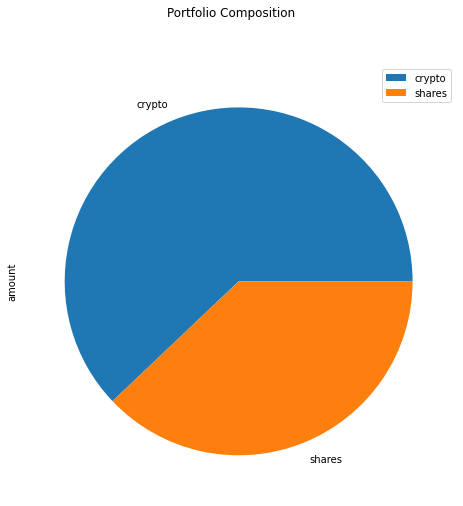

In [12]:
# Plot savings pie chart
df_savings.plot.pie(subplots=True,figsize=(8,8), title="Portfolio Composition")

In [13]:
# Set ideal emergency fund
#ideal emergency fund = 3x monthly income
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'].sum()

# Validate saving health
if total_savings > emergency_fund:
    print(f"Congratulations! You have enough money in your emergency fund.")
elif total_savings == emergency_fund:
    print(f"Congratulations! You have reached your emergency fund goal.")
else: print(f"You are ${(emergency_fund - total_savings):0.2f} away from reaching your goal")

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-04-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-04-01', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG

df_portfolio_5Y = alpaca.get_bars(
    tickers,
    timeframe,
    start= start_date,
    end= end_date
).df

# Reorganize the DataFrame
# Separate ticker data
SPY_5Y = df_portfolio_5Y[df_portfolio_5Y['symbol']== 'SPY'].drop('symbol', axis=1)
AGG_5Y = df_portfolio_5Y[df_portfolio_5Y['symbol']== 'AGG'].drop('symbol', axis=1)
# Concatenate the ticker DataFrames
df_stock_data = pd.concat([SPY_5Y, AGG_5Y], axis=1, keys=['SPY','AGG'])

# Display sample data
df_stock_data.head()

SPY                                      \
                             open    high      low   close     volume   
timestamp                                                               
2017-04-03 04:00:00+00:00  235.79  236.03  233.910  235.33   85546486   
2017-04-04 04:00:00+00:00  235.00  235.58  234.555  235.48   56466195   
2017-04-05 04:00:00+00:00  236.26  237.39  234.540  234.78  108800604   
2017-04-06 04:00:00+00:00  234.96  236.04  234.425  235.44   69135757   
2017-04-07 04:00:00+00:00  235.18  236.00  234.640  235.20   74412311   

                                                      AGG                   \
                          trade_count        vwap    open    high      low   
timestamp                                                                    
2017-04-03 04:00:00+00:00      278486  235.194832  108.31  108.68  108.300   
2017-04-04 04:00:00+00:00      192579  235.237449  108.61  108.65  108.520   
2017-04-05 04:00:00+00:00      363080  235.933657  108.48  108.74  108.453   
2017-04-06 04:00:00+00:00      244996  235.287745  108.64  108.71  108.480   
2017-04-07 04:00:00+00:00      235941  235.290964  108.80  108.89  108.420   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2017-04-03 04:00:00+00:00  108.67  5198006       15992  108.605513  
2017-04-04 04:00:00+00:00  108.57  1627492        8325  108.591265  
2017-04-05 04:00:00+00:00  108.69  2304074       11167  108.599103  
2017-04-06 04:00:00+00:00  108.68  1725301        7746  108.588276  
2017-04-07 04:00:00+00:00  108.44  1783599        8534  108.645684

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
#weightings are 60% Equities (SPY) vs 40% Bond (AGG) and the number of simulations = 500
MC_30year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [17]:
# Printing the simulation input data
MC_30year.portfolio_data.head()

SPY                                      \
                             open    high      low   close     volume   
timestamp                                                               
2017-04-03 04:00:00+00:00  235.79  236.03  233.910  235.33   85546486   
2017-04-04 04:00:00+00:00  235.00  235.58  234.555  235.48   56466195   
2017-04-05 04:00:00+00:00  236.26  237.39  234.540  234.78  108800604   
2017-04-06 04:00:00+00:00  234.96  236.04  234.425  235.44   69135757   
2017-04-07 04:00:00+00:00  235.18  236.00  234.640  235.20   74412311   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-04-03 04:00:00+00:00      278486  235.194832          NaN  108.31   
2017-04-04 04:00:00+00:00      192579  235.237449     0.000637  108.61   
2017-04-05 04:00:00+00:00      363080  235.933657    -0.002973  108.48   
2017-04-06 04:00:00+00:00      244996  235.287745     0.002811  108.64   
2017-04-07 04:00:00+00:00      235941  235.290964    -0.001019  108.80   

                                                                         \
                             high      low   close   volume trade_count   
timestamp                                                                 
2017-04-03 04:00:00+00:00  108.68  108.300  108.67  5198006       15992   
2017-04-04 04:00:00+00:00  108.65  108.520  108.57  1627492        8325   
2017-04-05 04:00:00+00:00  108.74  108.453  108.69  2304074       11167   
2017-04-06 04:00:00+00:00  108.71  108.480  108.68  1725301        7746   
2017-04-07 04:00:00+00:00  108.89  108.420  108.44  1783599        8534   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-04-03 04:00:00+00:00  108.605513          NaN  
2017-04-04 04:00:00+00:00  108.591265    -0.000920  
2017-04-05 04:00:00+00:00  108.599103     0.001105  
2017-04-06 04:00:00+00:00  108.588276    -0.000092  
2017-04-07 04:00:00+00:00  108.645684    -0.002208

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\15613\FinTechWork\Unit5-Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001233,0.985280,1.006829,0.991767,0.994202,1.002467,0.998212,1.003675,1.002302,1.004130,...,0.995298,1.010547,1.011997,1.007468,0.998417,1.011932,1.003281,1.000606,0.999888,1.012587
2,0.999529,0.989389,1.006146,0.991176,0.989933,0.983949,1.004117,1.016627,1.011134,1.001926,...,0.995096,1.013319,1.022336,1.003423,1.000197,1.016838,1.008805,1.009672,1.008055,1.011297
3,1.004477,0.985477,1.008877,1.010293,0.985993,0.982344,0.994459,1.017693,1.007351,1.017344,...,0.981040,1.006089,1.046707,1.008059,1.003975,0.999728,1.008095,1.010143,1.011163,1.008425
4,1.008164,0.986498,1.009610,1.021917,0.988242,0.994016,1.002159,1.011595,1.007667,1.021083,...,0.974603,1.002604,1.042194,1.011320,1.016685,1.007225,1.004564,1.009562,1.008002,1.010668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,8.821901,21.295239,7.878909,8.714091,22.364776,42.790262,15.407884,6.276974,15.899573,12.566027,...,11.635854,14.981405,14.914834,14.136779,4.568952,5.307914,10.227804,46.943861,16.671443,12.620414
7557,8.731970,21.176599,7.890243,8.799063,22.335128,42.744813,15.496567,6.213182,15.838541,12.644684,...,11.733042,15.106401,14.993689,14.243073,4.597164,5.359104,10.188285,46.115683,16.880341,12.496078
7558,8.562058,21.194922,7.881461,8.852278,22.384727,42.503231,15.416094,6.247019,15.831549,12.590535,...,11.826566,15.449495,15.034666,14.080436,4.571200,5.453625,10.193165,46.844539,16.650650,12.429552
7559,8.470106,21.269938,7.939884,8.815449,22.513863,42.627085,15.187980,6.287299,15.808953,12.510803,...,11.839539,15.578185,15.081272,14.178094,4.589369,5.469914,10.205808,46.119609,16.781781,12.506579


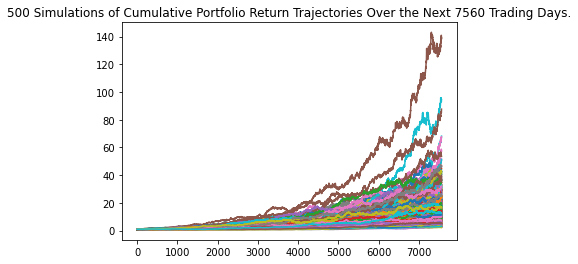

In [19]:
# Plot simulation outcomes
line_plot = MC_30year.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_30year_sim_plot.png", bbox_inches="tight")

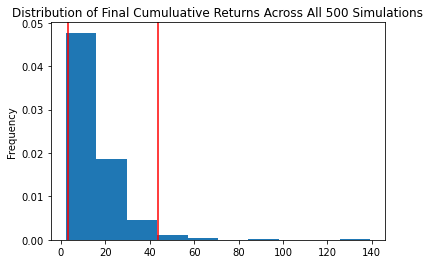

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30year.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_30year_dist_plot.png',bbox_inches='tight')

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_30year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean             15.517472
std              12.470608
min               2.222934
25%               7.831073
50%              12.534433
75%              19.675673
max             139.246650
95% CI Lower      3.396604
95% CI Upper     43.582936
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment_20k = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_20k = tbl[8] * initial_investment_20k
ci_upper_20k = tbl[9] * initial_investment_20k

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_20k} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_20k:0.2f} and ${ci_upper_20k:0.2f}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $67932.09 and $871658.71


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment_30k = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_30k = tbl[8] * initial_investment_30k
ci_upper_30k = tbl[9] * initial_investment_30k

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_30k} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_30k:0.2f} and ${ci_upper_30k:0.2f}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $101898.13 and $1307488.07


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [36]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
#weightings are 70% Equities (SPY) vs 30% Bond (AGG) with 500 simulations as a more aggressive portfolio
MC_5year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.70,.30],
    num_simulation = 500,
    num_trading_days = 252*5
)
#view the portfolio data table to check the order of the securities
MC_5year.portfolio_data.head()

SPY                                      \
                             open    high      low   close     volume   
timestamp                                                               
2017-04-03 04:00:00+00:00  235.79  236.03  233.910  235.33   85546486   
2017-04-04 04:00:00+00:00  235.00  235.58  234.555  235.48   56466195   
2017-04-05 04:00:00+00:00  236.26  237.39  234.540  234.78  108800604   
2017-04-06 04:00:00+00:00  234.96  236.04  234.425  235.44   69135757   
2017-04-07 04:00:00+00:00  235.18  236.00  234.640  235.20   74412311   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-04-03 04:00:00+00:00      278486  235.194832          NaN  108.31   
2017-04-04 04:00:00+00:00      192579  235.237449     0.000637  108.61   
2017-04-05 04:00:00+00:00      363080  235.933657    -0.002973  108.48   
2017-04-06 04:00:00+00:00      244996  235.287745     0.002811  108.64   
2017-04-07 04:00:00+00:00      235941  235.290964    -0.001019  108.80   

                                                                         \
                             high      low   close   volume trade_count   
timestamp                                                                 
2017-04-03 04:00:00+00:00  108.68  108.300  108.67  5198006       15992   
2017-04-04 04:00:00+00:00  108.65  108.520  108.57  1627492        8325   
2017-04-05 04:00:00+00:00  108.74  108.453  108.69  2304074       11167   
2017-04-06 04:00:00+00:00  108.71  108.480  108.68  1725301        7746   
2017-04-07 04:00:00+00:00  108.89  108.420  108.44  1783599        8534   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-04-03 04:00:00+00:00  108.605513          NaN  
2017-04-04 04:00:00+00:00  108.591265    -0.000920  
2017-04-05 04:00:00+00:00  108.599103     0.001105  
2017-04-06 04:00:00+00:00  108.588276    -0.000092  
2017-04-07 04:00:00+00:00  108.645684    -0.002208

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\15613\FinTechWork\Unit5-Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003780,0.995607,1.009249,1.002050,1.000096,0.994716,0.995801,1.021410,0.998790,1.006101,...,1.004025,0.997371,1.001116,1.009064,1.015184,0.999991,0.992174,0.991940,1.013172,1.004439
2,1.000343,0.997898,1.021379,0.979179,1.010433,1.001495,1.009470,1.011582,1.008404,1.006162,...,1.006608,0.985710,1.004734,0.997781,1.009685,1.016219,0.985697,0.992861,1.014406,1.012658
3,0.989678,0.990714,1.020791,0.996665,1.005647,1.009148,1.018528,1.013049,1.019138,1.010879,...,1.011042,0.990817,1.003082,1.010549,0.998305,1.025488,0.978756,0.996465,1.006699,1.023974
4,0.977190,0.991336,1.009741,0.984758,1.006925,1.007536,1.013430,1.003387,1.023435,1.005120,...,1.008208,0.991813,0.996386,1.003773,1.001936,1.024112,0.987829,0.991594,1.003222,1.012792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.646057,1.853252,1.182103,1.238232,1.454852,1.565161,1.559354,1.759535,2.014929,1.530648,...,1.551094,1.319498,1.397107,0.835781,0.980825,1.956312,1.348422,1.200582,1.824587,1.501886
1257,1.655534,1.858591,1.174700,1.240518,1.465793,1.564596,1.534919,1.741835,1.990025,1.525502,...,1.575845,1.333413,1.395126,0.851240,0.984714,1.977834,1.336539,1.230350,1.843485,1.492677
1258,1.659964,1.864932,1.140848,1.251179,1.464158,1.539655,1.544902,1.764465,1.994850,1.515431,...,1.604165,1.330417,1.409875,0.841680,1.003814,1.970878,1.347730,1.231894,1.834770,1.484975
1259,1.649723,1.871274,1.124167,1.255909,1.473284,1.553456,1.525453,1.755068,1.964563,1.503253,...,1.579266,1.318972,1.394010,0.845081,0.996840,1.966778,1.344915,1.215200,1.859010,1.496018


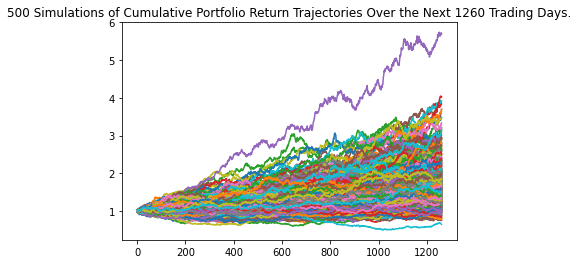

In [26]:
# Plot simulation outcomes
line_plot_5Y = MC_5year.plot_simulation()

# Save the plot for future usage
line_plot_5Y.get_figure().savefig("MC_5year_sim_plot.png", bbox_inches="tight")

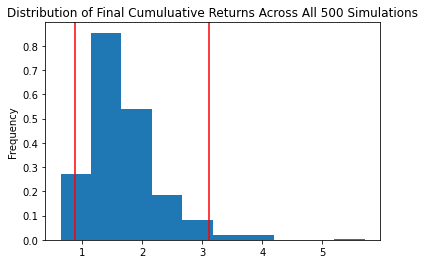

In [27]:
# Plot probability distribution and confidence intervals
dist_plot_5Y = MC_5year.plot_distribution()

# Save the plot for future usage
dist_plot_5Y.get_figure().savefig('MC_5year_dist_plot.png',bbox_inches='tight')

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_5Y = MC_5year.summarize_cumulative_return()

# Print summary statistics
print(tbl_5Y)

count           500.000000
mean              1.684192
std               0.586427
min               0.645786
25%               1.295175
50%               1.567071
75%               1.943493
max               5.705726
95% CI Lower      0.891204
95% CI Upper      3.113513
Name: 1260, dtype: float64


In [29]:
# Set initial investment
initial_investment_5y = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_5y = tbl_5Y[8] * initial_investment_5y
ci_upper_5y = tbl_5Y[9] * initial_investment_5y

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5y} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_5y:0.2f} and ${ci_upper_5y:0.2f}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $53472.24 and $186810.75


### Ten Years Retirement Option

In [37]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
#weightings are 70% Equities (SPY) vs 30% Bond (AGG) with 500 simulations as a more aggressive portfolio
MC_10year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.70,.30],
    num_simulation = 500,
    num_trading_days = 252*10
)
#view the portfolio data table to check the order of the securities
MC_10year.portfolio_data.head()

SPY                                      \
                             open    high      low   close     volume   
timestamp                                                               
2017-04-03 04:00:00+00:00  235.79  236.03  233.910  235.33   85546486   
2017-04-04 04:00:00+00:00  235.00  235.58  234.555  235.48   56466195   
2017-04-05 04:00:00+00:00  236.26  237.39  234.540  234.78  108800604   
2017-04-06 04:00:00+00:00  234.96  236.04  234.425  235.44   69135757   
2017-04-07 04:00:00+00:00  235.18  236.00  234.640  235.20   74412311   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-04-03 04:00:00+00:00      278486  235.194832          NaN  108.31   
2017-04-04 04:00:00+00:00      192579  235.237449     0.000637  108.61   
2017-04-05 04:00:00+00:00      363080  235.933657    -0.002973  108.48   
2017-04-06 04:00:00+00:00      244996  235.287745     0.002811  108.64   
2017-04-07 04:00:00+00:00      235941  235.290964    -0.001019  108.80   

                                                                         \
                             high      low   close   volume trade_count   
timestamp                                                                 
2017-04-03 04:00:00+00:00  108.68  108.300  108.67  5198006       15992   
2017-04-04 04:00:00+00:00  108.65  108.520  108.57  1627492        8325   
2017-04-05 04:00:00+00:00  108.74  108.453  108.69  2304074       11167   
2017-04-06 04:00:00+00:00  108.71  108.480  108.68  1725301        7746   
2017-04-07 04:00:00+00:00  108.89  108.420  108.44  1783599        8534   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-04-03 04:00:00+00:00  108.605513          NaN  
2017-04-04 04:00:00+00:00  108.591265    -0.000920  
2017-04-05 04:00:00+00:00  108.599103     0.001105  
2017-04-06 04:00:00+00:00  108.588276    -0.000092  
2017-04-07 04:00:00+00:00  108.645684    -0.002208

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\15613\FinTechWork\Unit5-Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004616,1.006502,0.992773,1.002719,1.011849,0.996908,1.007663,1.013172,0.990853,1.003081,...,0.999013,0.995533,1.001652,1.005450,1.008979,0.991977,1.013293,0.996537,0.997501,0.999309
2,1.015173,0.998665,0.991281,0.998017,1.010892,1.001308,0.994172,1.032308,0.990642,0.996821,...,0.992662,0.997242,1.000024,1.007928,0.993817,0.975783,1.002767,0.975243,0.990888,1.002860
3,1.009088,1.015705,0.996335,0.999298,1.009777,1.000557,0.994215,1.025174,0.973835,0.995924,...,0.999282,1.009012,1.000537,1.009288,1.008106,1.001295,1.013597,0.977960,0.993019,0.994077
4,1.011666,1.001813,0.990652,1.010574,1.018840,1.009040,1.001898,1.027402,0.964127,1.002494,...,1.001786,1.009382,0.996546,1.009188,0.997915,0.989547,1.013288,0.973134,0.989092,1.001277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,5.605925,3.237836,2.225923,11.807450,2.597743,0.960199,3.869003,2.462662,0.673754,3.022777,...,2.361015,1.548129,2.826519,2.760588,2.190192,3.234473,3.256618,4.118137,3.682091,0.933531
2517,5.668223,3.198234,2.216919,11.924934,2.628781,0.960621,3.870329,2.465950,0.673008,3.043220,...,2.372952,1.544585,2.838161,2.811097,2.206810,3.245463,3.293195,4.018002,3.721862,0.930910
2518,5.580701,3.244147,2.192769,12.123504,2.606260,0.950274,3.845480,2.464930,0.674543,3.043700,...,2.331236,1.565218,2.869422,2.829345,2.210475,3.242264,3.308064,4.068241,3.748964,0.939728
2519,5.621923,3.245327,2.206565,12.121429,2.618711,0.942274,3.771651,2.437103,0.675651,3.029936,...,2.326999,1.537455,2.874544,2.799214,2.171476,3.229895,3.299628,4.095877,3.723547,0.944634


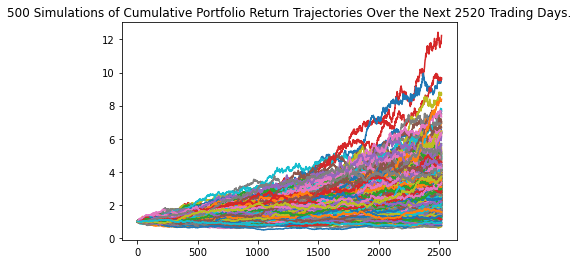

In [32]:
# Plot simulation outcomes
line_plot_10Y = MC_10year.plot_simulation()

# Save the plot for future usage
line_plot_10Y.get_figure().savefig("MC_10year_sim_plot.png", bbox_inches="tight")

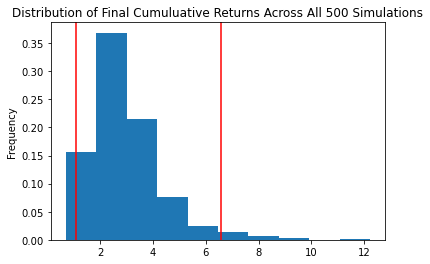

In [33]:
# Plot probability distribution and confidence intervals
dist_plot_10Y = MC_10year.plot_distribution()

# Save the plot for future usage
dist_plot_10Y.get_figure().savefig('MC_10year_dist_plot.png',bbox_inches='tight')

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_10Y = MC_10year.summarize_cumulative_return()

# Print summary statistics
print(tbl_10Y)

count           500.000000
mean              2.972248
std               1.435278
min               0.682813
25%               2.111827
50%               2.610530
75%               3.594513
max              12.238534
95% CI Lower      1.077357
95% CI Upper      6.580430
Name: 2520, dtype: float64


In [35]:
# Set initial investment
initial_investment_10y = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_10y = tbl_10Y[8] * initial_investment_10y
ci_upper_10y = tbl_10Y[9] * initial_investment_10y

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10y} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_10y:0.2f} and ${ci_upper_10y:0.2f}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $64641.40 and $394825.81
